# MARS5001 Coastal Processes and Systems 


## NB1 - Shallow Water Equation 1D

<br />
<br />
<br />

# Overview

<p>The shallow water equations ( **SWE** ) are hyperbolic partial differential equations that describe fluid flow when the fluid is *"shallow"*.</p> 

<p>They're derived from the Navier-Stokes equations for cases where horizontal length is much greater than vertical length. The vertical velocity is assumed to be effectively zero and so the horizontal velocity is constant throughout the height of the fluid column.</p>

<p>In this notebook we will use ClawPack & PyClaw (documents for these <a href='http://www.clawpack.org/doc/pyclaw/'>modules</a>) to design a 1D model of the SWE.</p>

# SWE Theory

## Derivation from Navier-Stokes equations

The 1-D Saint Venant equation can be derived from the Navier-Stokes equations that describe fluid motion. The Saint Venant equation when expressed in Cartesian coordinates in the x direction can be written as:
<br/>

$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} +  v\frac{\partial u}{\partial y} + w \frac{\partial u}{\partial z} = \frac{1}{\rho} \frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial^2 x}+\frac{\partial^2 u}{\partial^2 y}+\frac{\partial^2 u}{\partial^2 z} \right) + f_x $$

+ $u,v,w$: velocity in $x,y,z$ direction
+ $t$: time
+ $p$: pressure
+ $\rho$: density of water
+ $\nu$: kinematic viscosity 
+ $f_x$: body force

<br/>

### Assumptions

#### 1- Friction part of the body force ($\nu=0$)
$\nu \left( \frac{\partial^2 u}{\partial^2 x}+\frac{\partial^2 u}{\partial^2 y}+\frac{\partial^2 u}{\partial^2 z} \right)  = 0$
<br/><br/>

#### 2- 1D flow
Simplifies to:
$v\frac{\partial u}{\partial y} + w \frac{\partial u}{\partial z}  = 0$
<br/><br/>

#### 3- Hydrostatic pressure
It gives:
$p  = \rho gh$    &mdash; differential form:  $\partial p  = \rho g \partial h$  with $h$ is the free surface elevation
<br/><br/>

#### 4- Limited forcing
Limiting to gravity and friction for $f_x$ with:
<br/>
+ $f_{x,g}=gS$ the gravity force depending on the slope $S$
+ $f_{x,f}=gS_f$ a slope dependent friction force 
<br/><br/>


## SWE (Saint Venant) 1D

All the above assumptions simplifies our initial momentum conservation equation to:
<br/>
$$ \frac{\partial u}{\partial t} + u\frac{\partial (u)}{\partial x} + g \frac{\partial h}{\partial x} + g(S-S_f) = 0$$
<br/>
where: 

* term 1 is the local acceleration term (**INERTIA**), 
* term 2 is the convective acceleration term (**INERTIA**), 
* term 3 is the pressure gradient term, 
* term 4 is the gravity term, and 
* term 5 is the friction term.

## Some notes on the derivation of the SWE

In [8]:
from IPython.core.display import HTML
HTML('<iframe src=http://kiwi.atmos.colostate.edu/group/dave/pdf/ShallowWater.pdf width=600 height=500></iframe>')

# Applications
Shallow water equations model the propagation of disturbances in water and other incompressible fluids. They are used extensively for (natural?) hazards such as tsunami (<a href='http://au.mathworks.com/moler/exm/chapters/water.pdf'>simple application to tsunami</a>) or flood modeling.


## SWE dam break  

In [9]:
from IPython.core.display import HTML
HTML('<iframe src=https://rivercityrevolution.files.wordpress.com/2009/01/dam_break.jpg width=500 height=400 name="left"></iframe>'
    '<iframe src=http://www.flow3d.com/wp-content/uploads/2014/03/shallow-water-dam-break.jpg width=500 height=400 name="right"></iframe>')

## SWE tsunami

In [10]:
from IPython.core.display import HTML
HTML('<iframe src=http://i.telegraph.co.uk/multimedia/archive/02162/20110311-tsunami-w_2162733k.jpg width=600 height=400 name="left"></iframe>'
    '<iframe src=http://sos.noaa.gov/videos/new_tsunami.mov width=400 height=400 name="right"></iframe>')


# Getting started

We will use Clawpack/PyClaw modules to build our own SWE model. 

So we simply import the modules we will need!


<small>
**Acknowlegement** &mdash; This  is based on the teaching material compiled by Prof. L. Barba <a href:'https://github.com/barbagroup/PASI2013/blob/master/README.md'>PASI program</a>: I will highly recommend to have a look at this website.
</small>



In [1]:
%matplotlib inline
from clawpack import riemann
from clawpack import pyclaw
import numpy 
from matplotlib import animation
from JSAnimation import IPython_display

## Discretisation & solver

<p>To solve partial differential equations (**PDEs**), we usually discretise the system of equations both temporally and spatially. </p>
<p>Based on the type of systems there are different methods to represent them in the form of algebraic equations, such as:</p>

* Finite difference
* Finite element
* Finite volume

<p>Then depending of the problem we need to solve, we have to use specific type of solvers. The choice of solvers depends on at least 3 things: <br/> **robustness, efficiency & reusability**. </p>

<p>Clawpack has a number of built in Riemann solvers which are coded in Fortran for nice fast results. Pyclaw functions as a bridge to allow us to make use of these Fortran routines from within Python.</p>

<p>We use the following conservative equations for the SWE:</p>

$$ \frac{\partial H}{\partial t} + \frac{\partial (UH)}{\partial x} = 0 $$
$$ \frac{\partial UH}{\partial t} + \frac{\partial (U^2H+gH^2/2)}{\partial x} = 0 $$

<p>Here $U$ is the ordinary velocity, $H$ is the height of the water column and $g$ is the gravitational acceleration.

<p>For any problem, we have to choose the appropriate Riemann solver.
For these equations, the Clawpack solver we want is called <code>shallow_roe_with_efix_1D</code>.</p>

In [2]:
rs = riemann.shallow_roe_with_efix_1D 

Next, we need to tell Pyclaw that we're going to be using this Riemann solver and also apply a 'limiter' to the problem. Limiters are any one of several routines to help prevent problems from blowing up. For this problem, we'll use a wave limiter called Vanleer.

In [3]:
solver = pyclaw.ClawSolver1D(rs)
solver.limiters = pyclaw.limiters.tvd.vanleer

We also have to tell our solver that we're using a Fortran routine to run this problem.

In [4]:
solver.kernel_language='Fortran'

## Domain definition 

Ok, now it's time to set up our domain. We have to choose a range to run the problem over, and the number of grid points that we'd like to insert.

In [5]:
xlower = -5.0
xupper = 5.0
mx = 200
x = pyclaw.Dimension('x',xlower,xupper,mx)
domain = pyclaw.Domain(x)

Note now that x is a Pyclaw geometry object.

In [6]:
print x

Dimension x:  (num_cells,delta,[lower,upper]) = (200,0.05,[-5.0,5.0])


### Pyclaw object

Next we have to initialize the Pyclaw "state" object. The state object keeps track of our domain as the solver progresses. We need to tell it what our domain looks like (conveniently stashed in our variable x) and also how many equations are in our problem. Since we're working with a 1D shallow water problem, we need two equations

In [8]:
domain = pyclaw.Domain(x)
num_eqn = 2
state = pyclaw.State(domain,num_eqn)
state.problem_data['grav'] = 1

### Initial conditions

Ok, now let's set up our initial conditions. We'll be looking at a classic shallow water example, the 'dam break.' We're going to set up a 'step' of water and then see what happens when we let it go. First, let's grab the positions of our nodes from our state object.

In [9]:
xc = state.grid.x.centers

For the sake of simplicity, we'll choose $x=0$ as our point to divide the high and low water sections. Everything to the left of x=0 will have a height of 3, while everything to the right will have a height of 1. We also need to specify an initial velocity at each node. Again, for simplicity, we're going to set $u=0$ everywhere.

Now, because we need Pyclaw to understand what we're asking it, we need to make sure we put this information in the right place. In this setup, we need to put our water height information into the first row of the state.q array, and the velocity information into the second row.

In [10]:
x0 = 0

hl = 3.
hr = 1.
state.q[0,:] = hl * (xc <= x0) + hr * (xc > x0)
state.q[1,:] = xc*0

### Visualising the initial conditions

Let's do a quick plot of those initial conditions to make sure they turned out the way we expected.

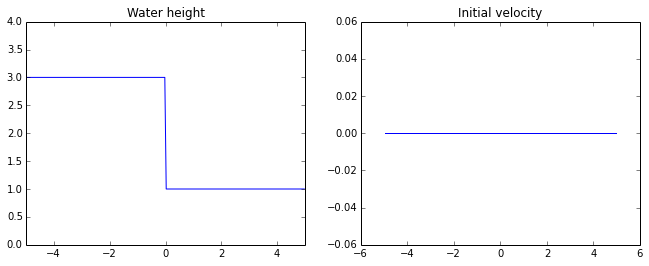

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(xc, state.q[0,:])
plt.axis([-5,5,0,4])
plt.title('Water height')
plt.subplot(122)
plt.plot(xc, state.q[1,:])
plt.title('Initial velocity');

### Boundary conditions

Looking good! Now just a little more housekeeping and we should be good to go. We need to specify boundary conditions so the solver knows what to do at the edges of our domain. For a dam break simulation, outflow boundaries make the most sense.

In [12]:
solver.bc_lower[0] = pyclaw.BC.extrap
solver.bc_upper[0] = pyclaw.BC.extrap

Finally, we need to specify a few things. We need to create our 'controller' which will manage the problem for us. It keeps track of how long to run the simulation, how many frames to divide it into, and where/if to store results.

In [13]:
claw = pyclaw.Controller()
claw.keep_copy = True
claw.tfinal = 3.0
claw.solution = pyclaw.Solution(state,domain)
claw.solver = solver
claw.output_format = None 
claw.num_output_times = 50

## Run PyClaw SWE model

In [14]:
status = claw.run();

2015-03-13 03:10:41,204 INFO CLAW: Solution 0 computed for time t=0.000000
2015-03-13 03:10:41,206 INFO CLAW: Solution 1 computed for time t=0.060000
2015-03-13 03:10:41,208 INFO CLAW: Solution 2 computed for time t=0.120000
2015-03-13 03:10:41,210 INFO CLAW: Solution 3 computed for time t=0.180000
2015-03-13 03:10:41,212 INFO CLAW: Solution 4 computed for time t=0.240000
2015-03-13 03:10:41,214 INFO CLAW: Solution 5 computed for time t=0.300000
2015-03-13 03:10:41,216 INFO CLAW: Solution 6 computed for time t=0.360000
2015-03-13 03:10:41,218 INFO CLAW: Solution 7 computed for time t=0.420000
2015-03-13 03:10:41,219 INFO CLAW: Solution 8 computed for time t=0.480000
2015-03-13 03:10:41,221 INFO CLAW: Solution 9 computed for time t=0.540000
2015-03-13 03:10:41,223 INFO CLAW: Solution 10 computed for time t=0.600000
2015-03-13 03:10:41,225 INFO CLAW: Solution 11 computed for time t=0.660000
2015-03-13 03:10:41,227 INFO CLAW: Solution 12 computed for time t=0.720000
2015-03-13 03:10:41,22

Ok! So our solver has, well, solved our problem. It's split it up into 50 frames, just as we specified, and it's covered 3 seconds of simulation time, again as we've specified. Now let's take a look at the results!

## Plotting results

The solution for each frame is stored within the array claw.frames, so we can easily use matplotlib to take a look at a given frame of our solution. Just like with our initial setup, the fluid height is stored in the first row of q and the velocity is stored in the second row.

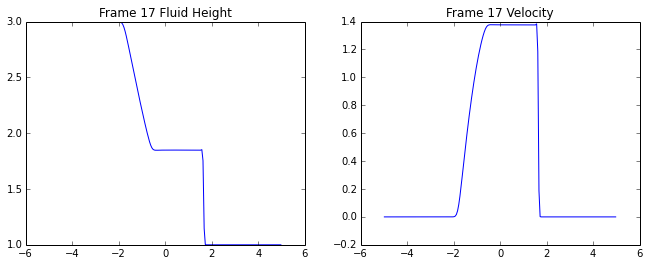

In [15]:
x = domain.grid.x.centers.copy()

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(x, claw.frames[17].q[0,:])
plt.title('Frame 17 Fluid Height')

plt.subplot(122)
plt.plot(x, claw.frames[17].q[1,:])
plt.title('Frame 17 Velocity');

## Animating results

We're going to make use of the JSAnimation library to animate our solutions into a small movie. You can read up here about how the JSAnimation library works.


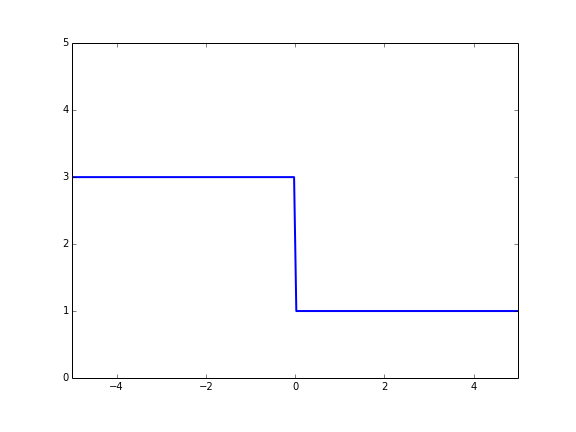
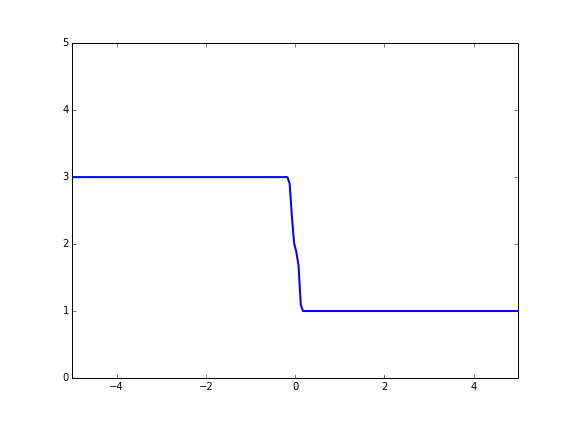
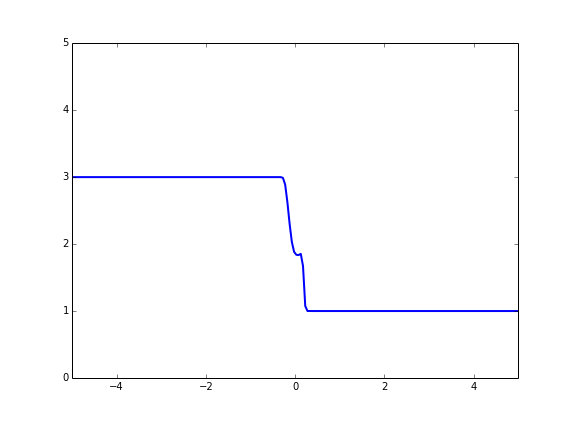
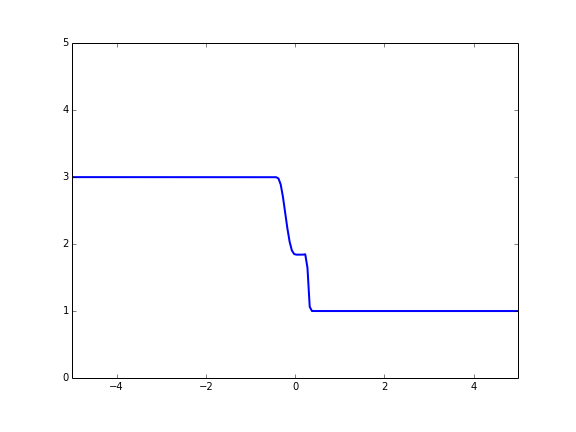
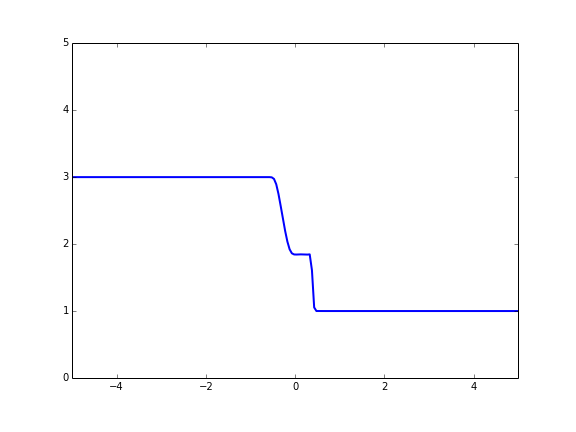
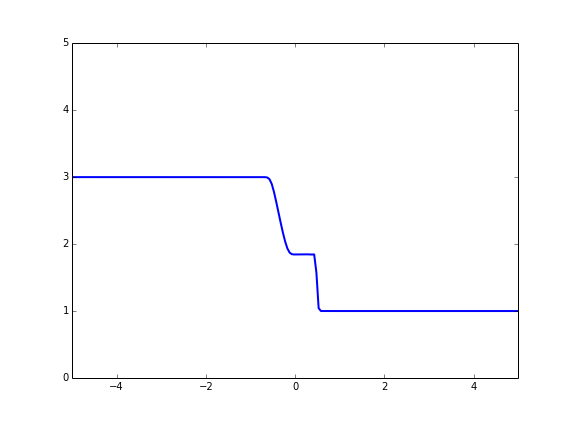
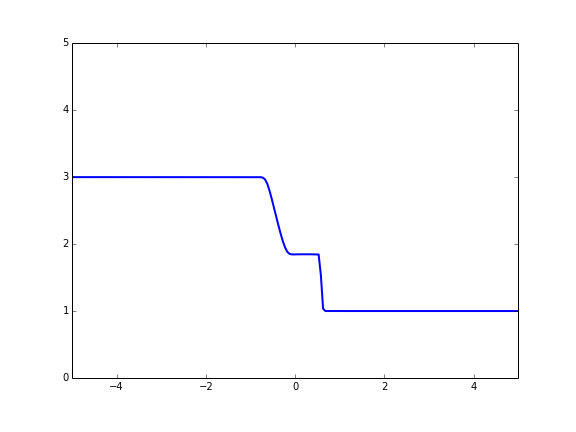
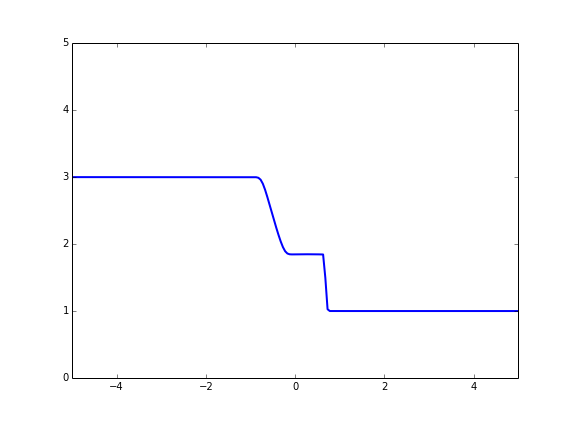
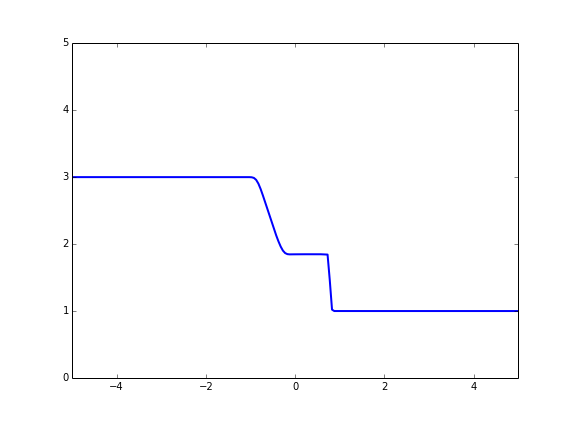
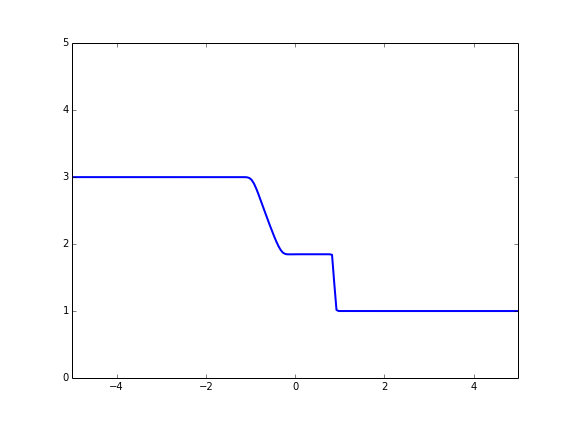
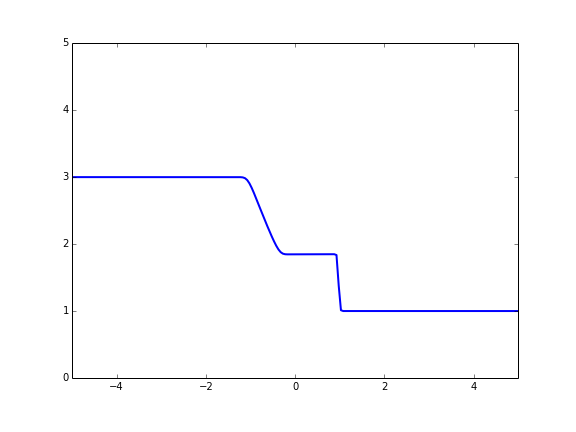
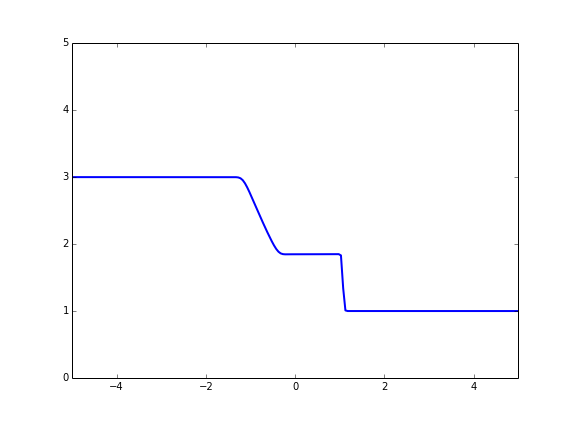
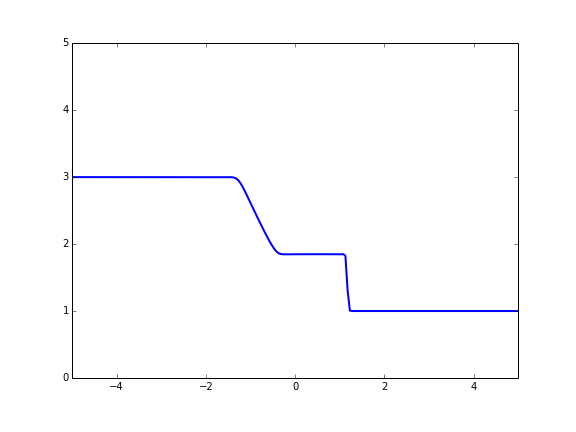
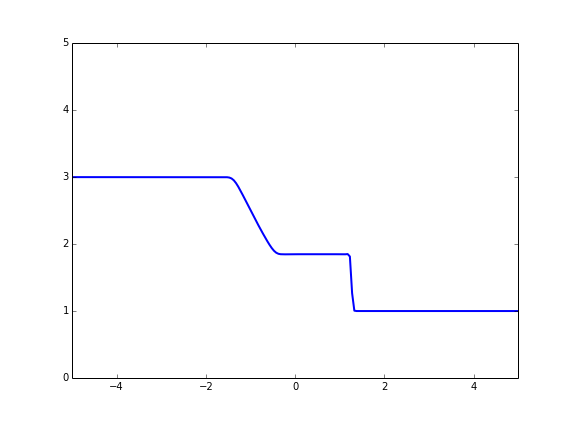
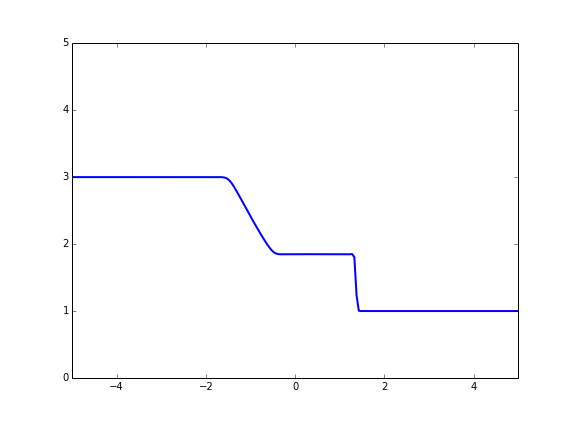
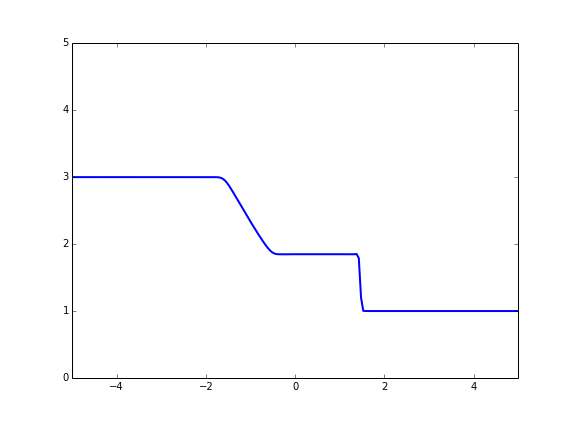
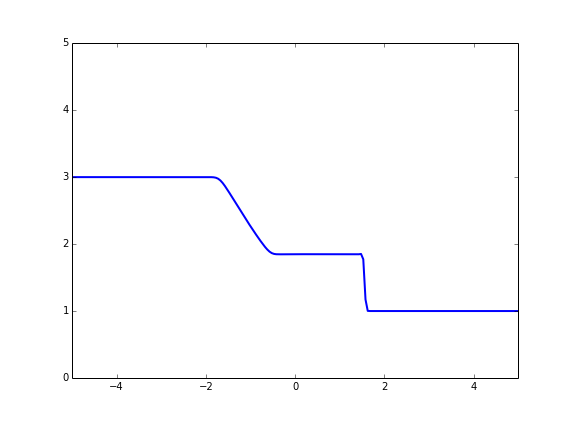
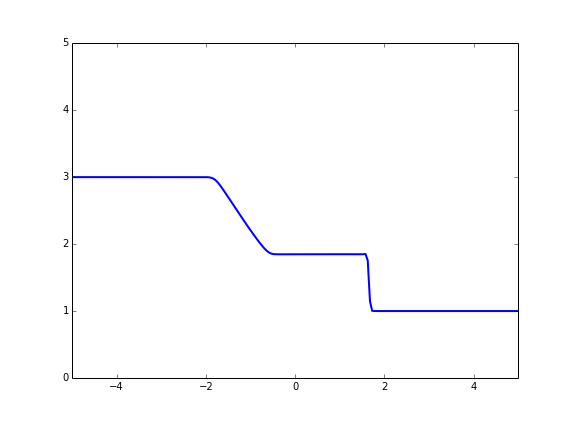
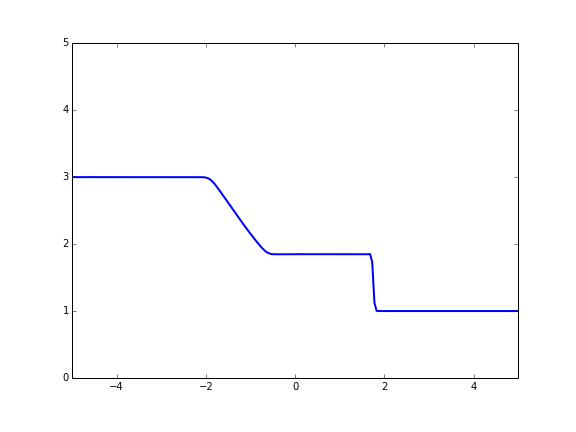
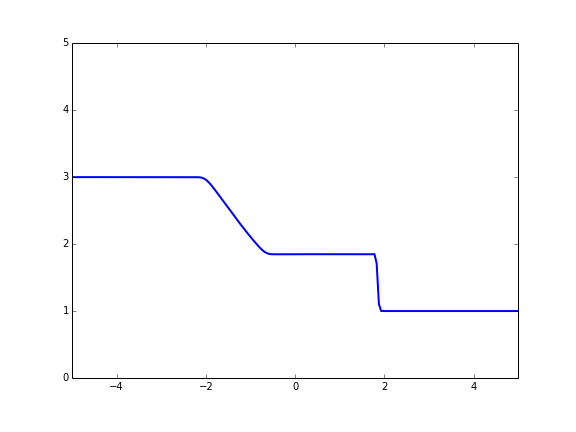
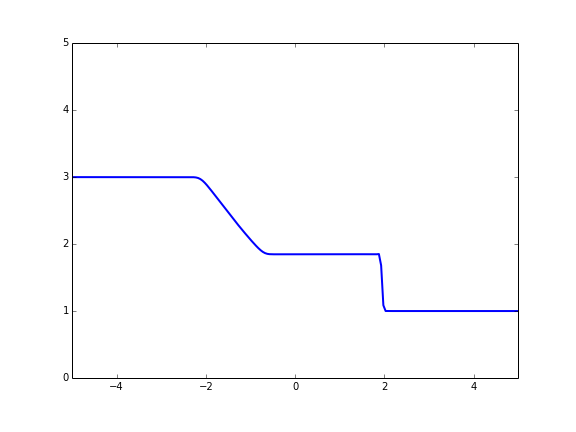
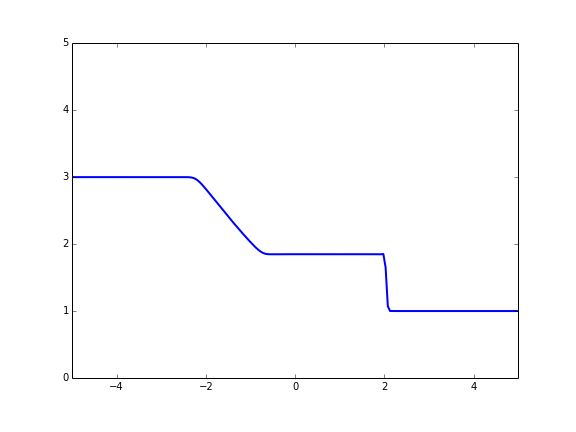
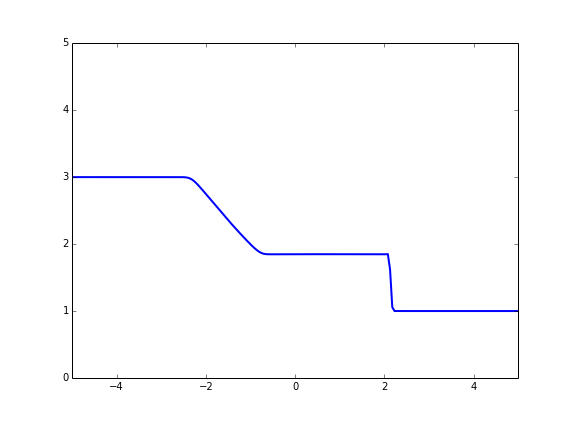
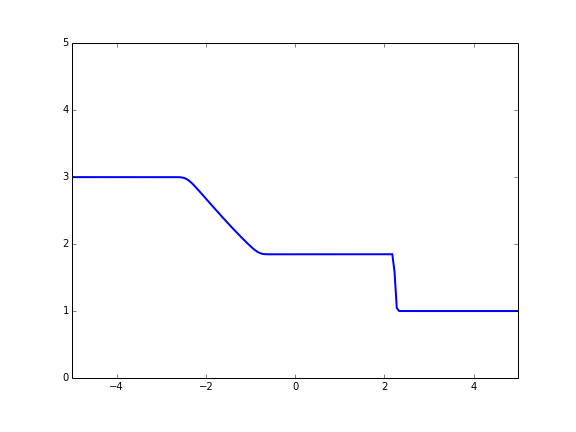
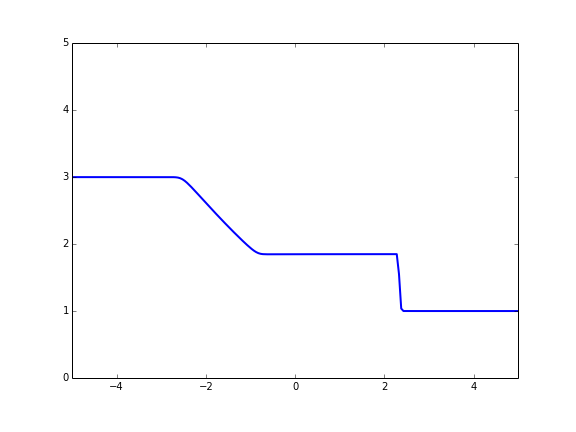
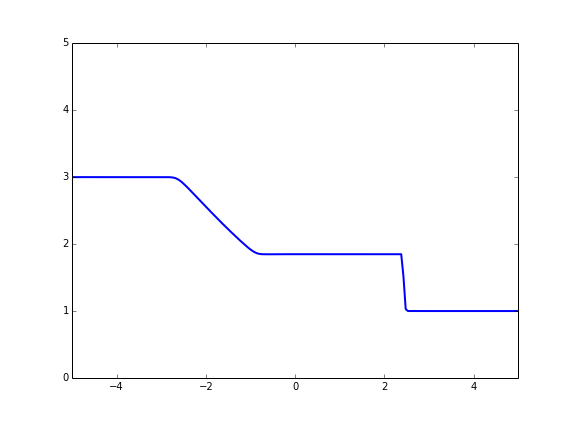
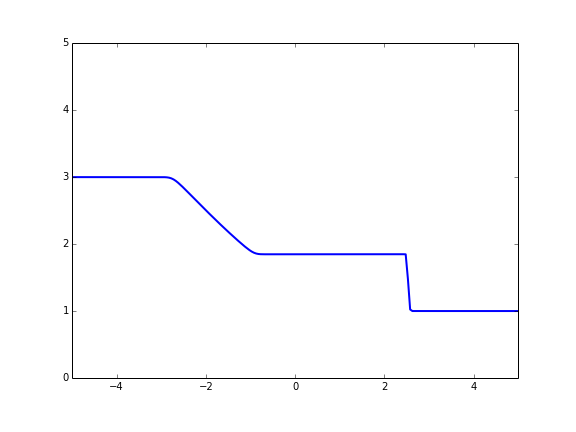
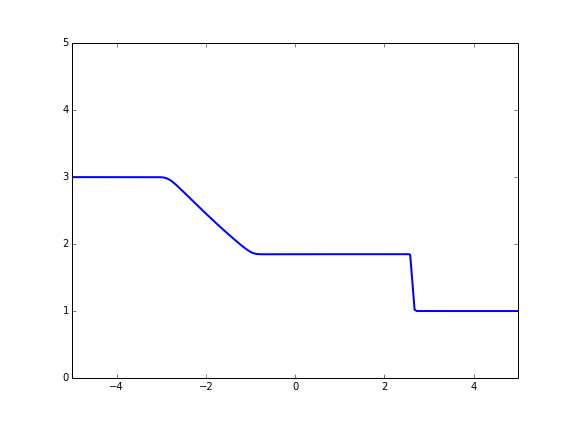
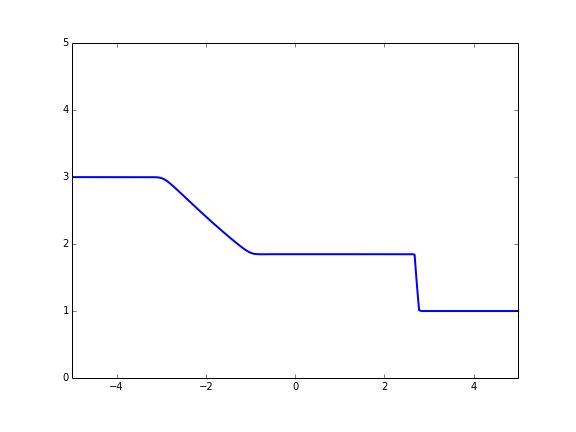
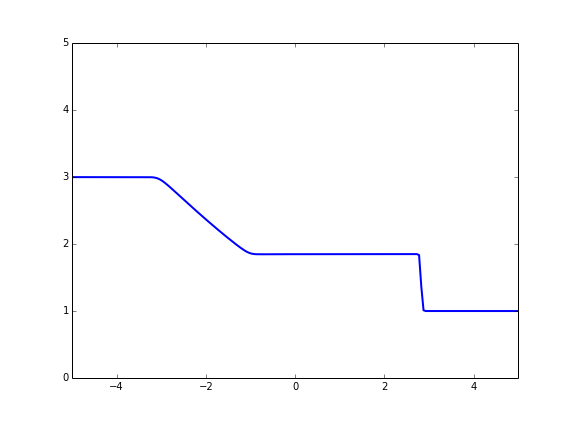
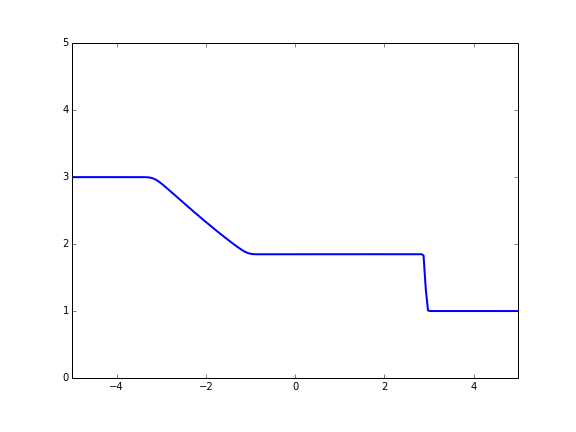
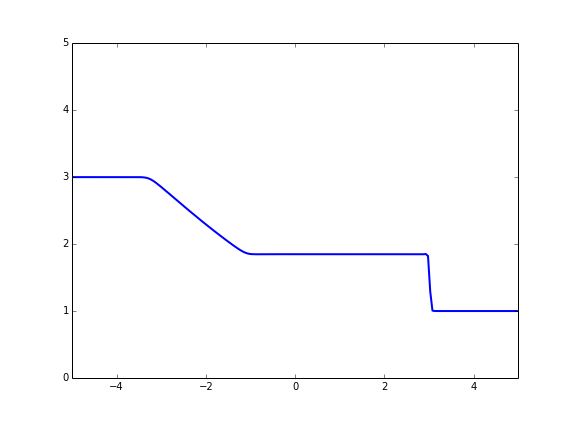
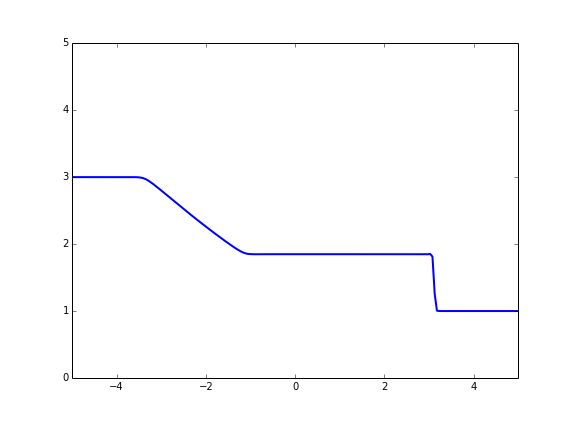
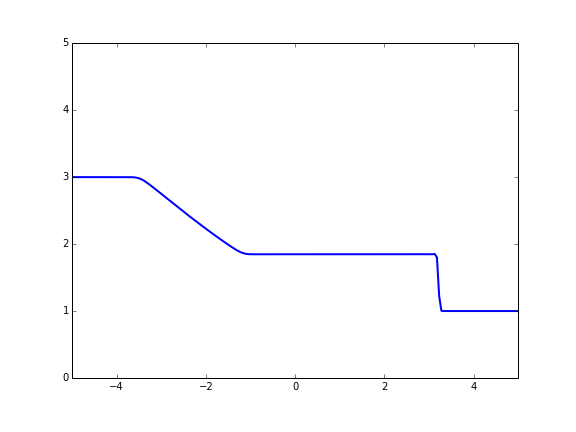
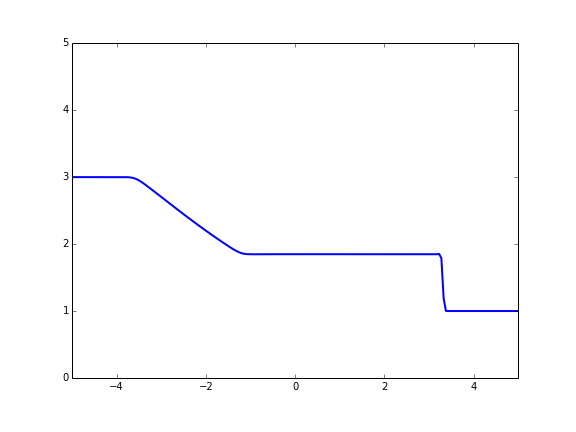
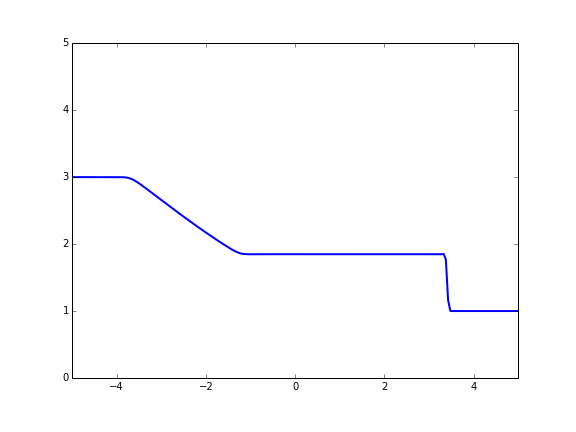
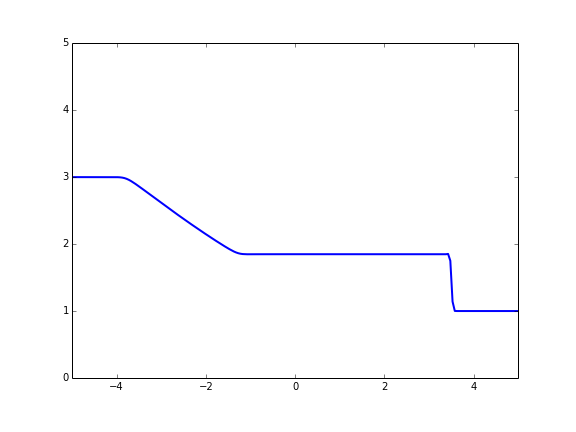
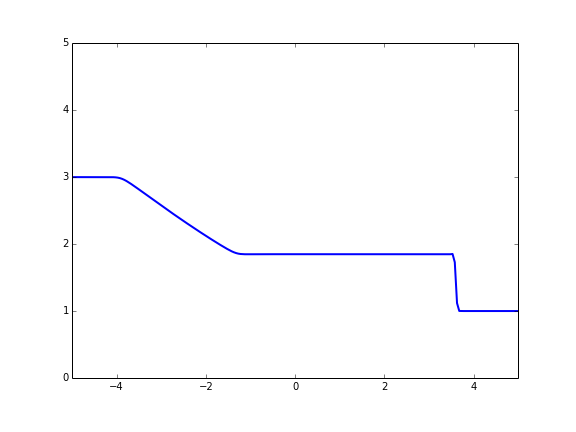
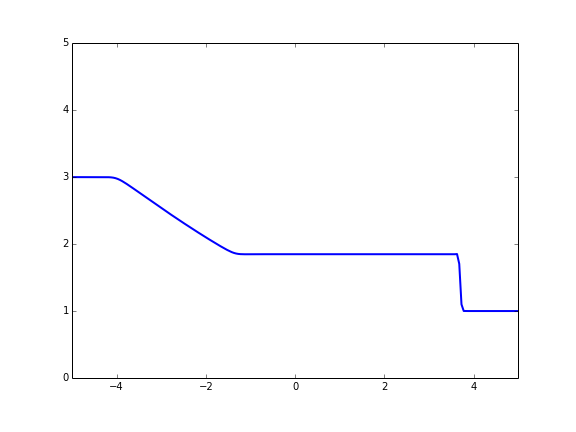
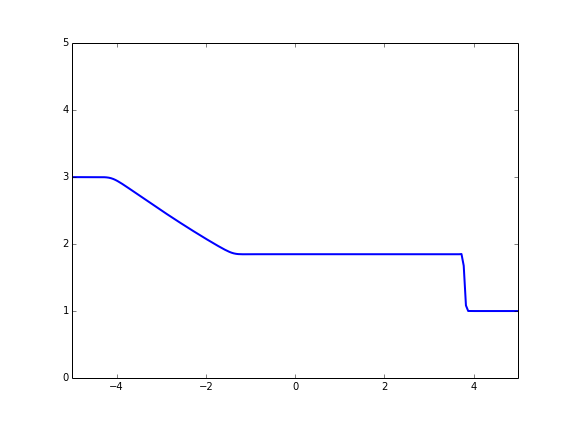
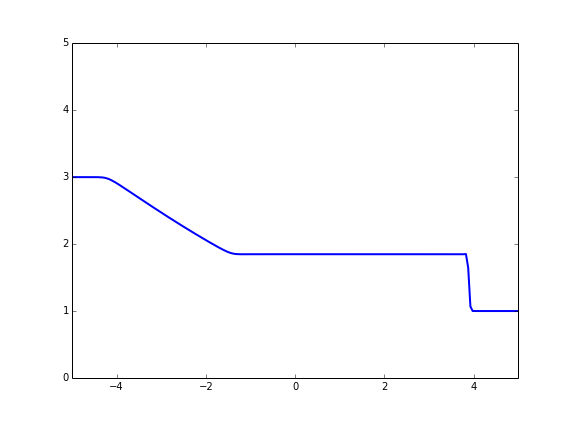
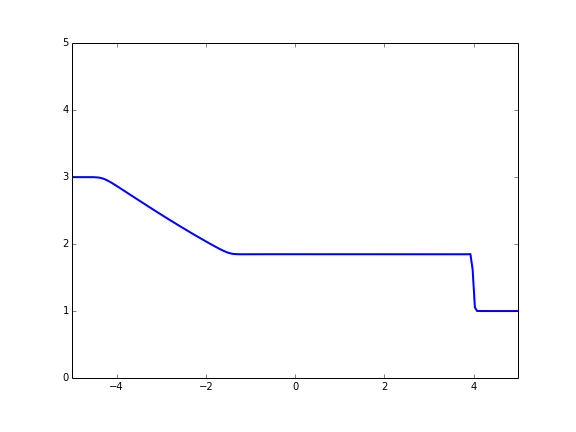
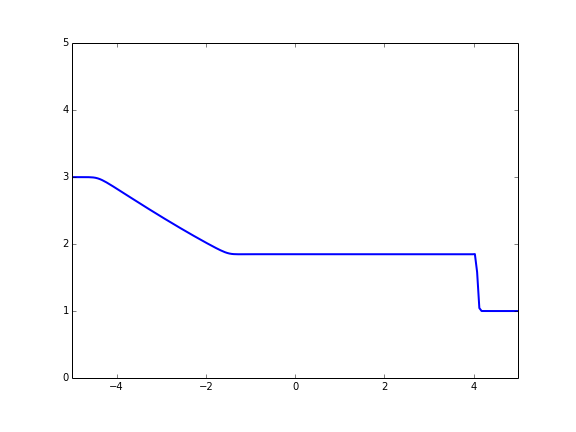
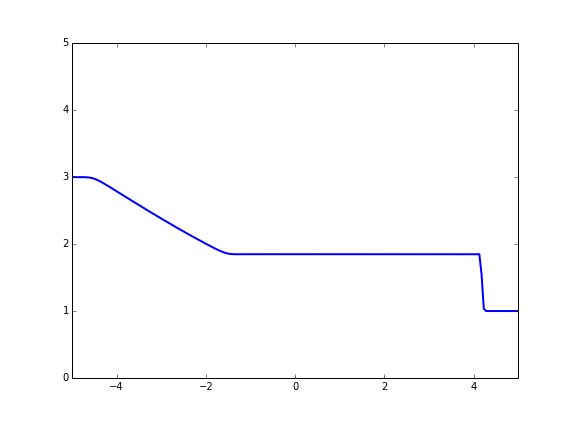
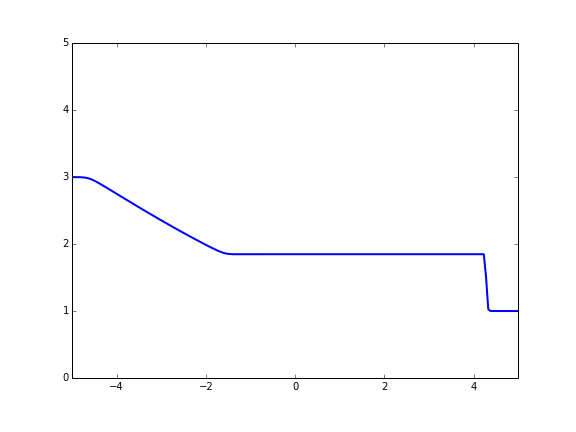
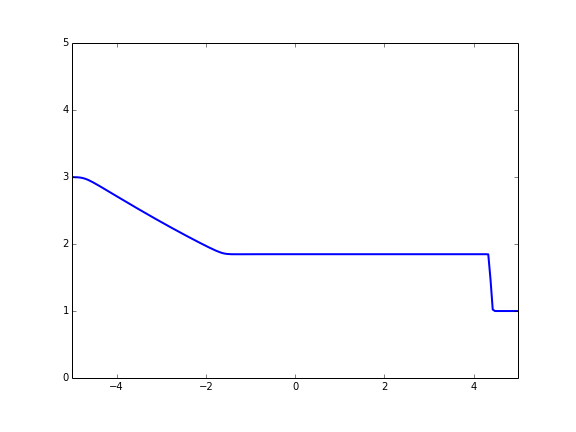
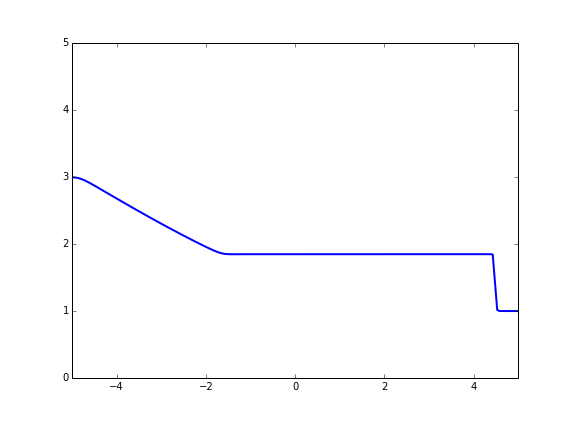
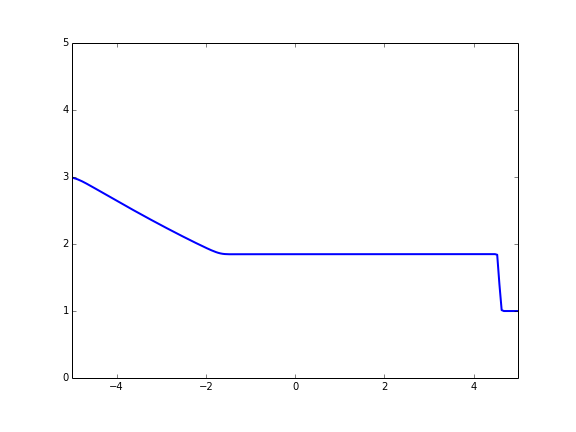
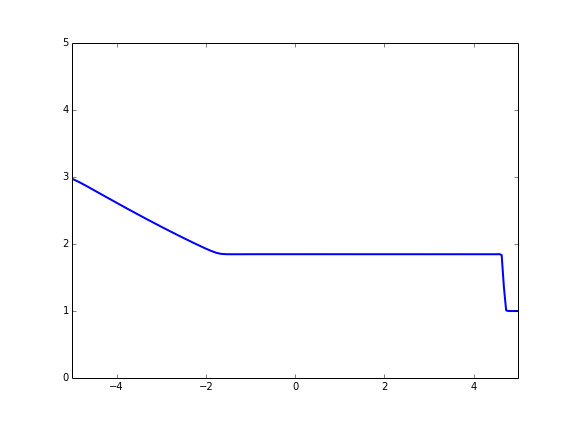
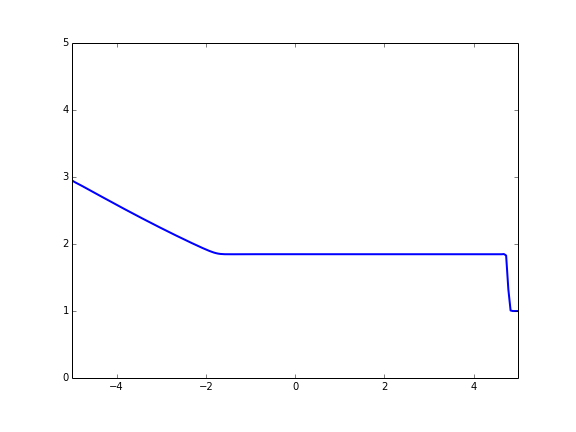

In [16]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(xlim=(-5, 5), ylim=(0, 5))

frame = claw.frames[0]
pressure = frame.q[0,:]
line, = ax.plot([], [], lw=2)

def fplot(i):
    frame = claw.frames[i]
    line.set_data(x,frame.q[0,:])
    return line,

animation.FuncAnimation(fig, fplot, 50, interval=40)

Cool! Once you have the hang of setting up the solvers, it's very easy to reinitialize a problem and change the initial conditions. Here's the same setup but instead of a dam break, we have a perturbation that could model what happens when a droplet of water hits a puddle.

In [21]:
solver = pyclaw.ClawSolver1D(rs)
solver.limiters = pyclaw.limiters.tvd.vanleer
solver.kernel_language='Fortran'

state = pyclaw.State(domain,num_eqn)
state.problem_data['grav'] = 1.0

solver.bc_lower[0] = pyclaw.BC.extrap
solver.bc_upper[0] = pyclaw.BC.extrap

x0=0
eps=0.5
state.q[0,:] = 1.0 + eps*numpy.exp(-(xc-x0)**2/0.5)
state.q[1,:] = 0.

claw = pyclaw.Controller()
claw.keep_copy = True
claw.tfinal = 3.0
claw.solution = pyclaw.Solution(state,domain)
claw.solver = solver
claw.output_format = None 
claw.num_output_times = 50

In [22]:
claw.run()

2015-03-08 21:02:18,314 INFO CLAW: Solution 0 computed for time t=0.000000
2015-03-08 21:02:18,316 INFO CLAW: Solution 1 computed for time t=0.060000
2015-03-08 21:02:18,318 INFO CLAW: Solution 2 computed for time t=0.120000
2015-03-08 21:02:18,319 INFO CLAW: Solution 3 computed for time t=0.180000
2015-03-08 21:02:18,321 INFO CLAW: Solution 4 computed for time t=0.240000
2015-03-08 21:02:18,323 INFO CLAW: Solution 5 computed for time t=0.300000
2015-03-08 21:02:18,325 INFO CLAW: Solution 6 computed for time t=0.360000
2015-03-08 21:02:18,326 INFO CLAW: Solution 7 computed for time t=0.420000
2015-03-08 21:02:18,327 INFO CLAW: Solution 8 computed for time t=0.480000
2015-03-08 21:02:18,329 INFO CLAW: Solution 9 computed for time t=0.540000
2015-03-08 21:02:18,330 INFO CLAW: Solution 10 computed for time t=0.600000
2015-03-08 21:02:18,332 INFO CLAW: Solution 11 computed for time t=0.660000
2015-03-08 21:02:18,333 INFO CLAW: Solution 12 computed for time t=0.720000
2015-03-08 21:02:18,33

{'cflmax': 0.9050358709266332,
 'dtmax': 0.036749998404948234,
 'dtmin': 0.033699477297272531,
 'numsteps': 100}


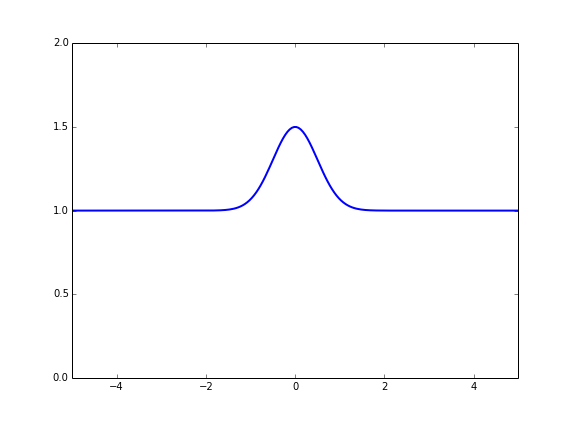
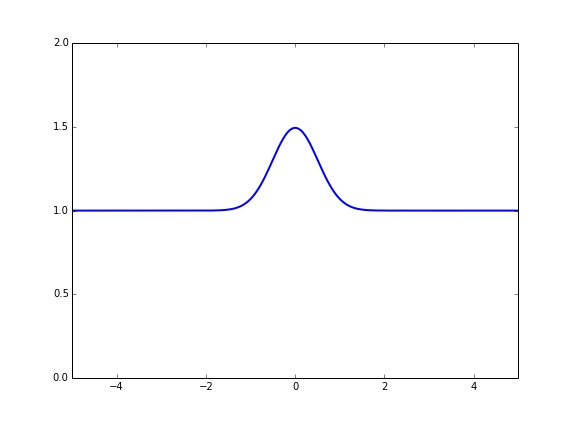
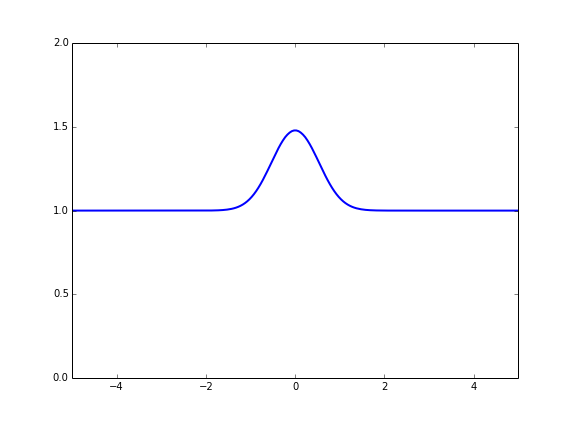
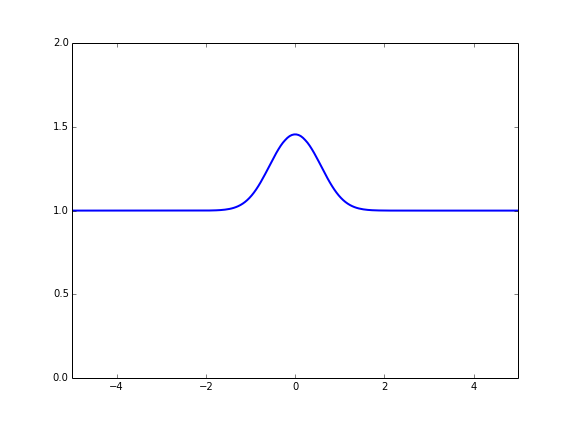
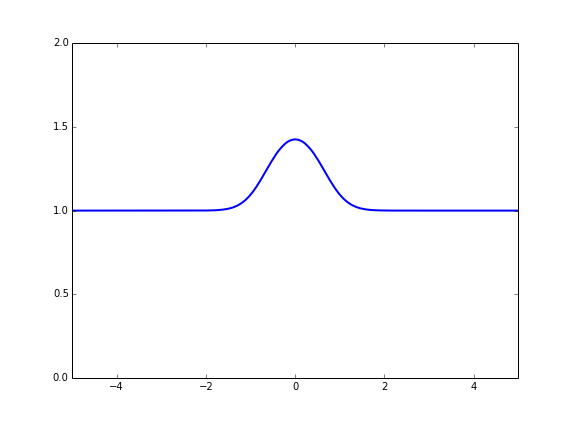
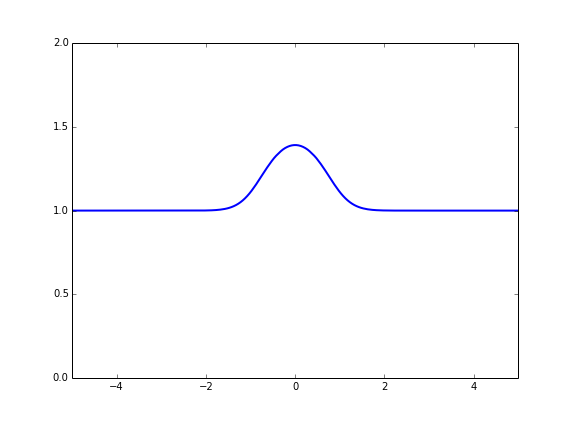
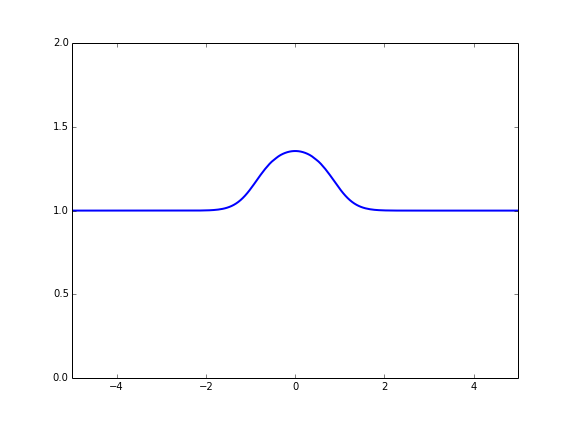
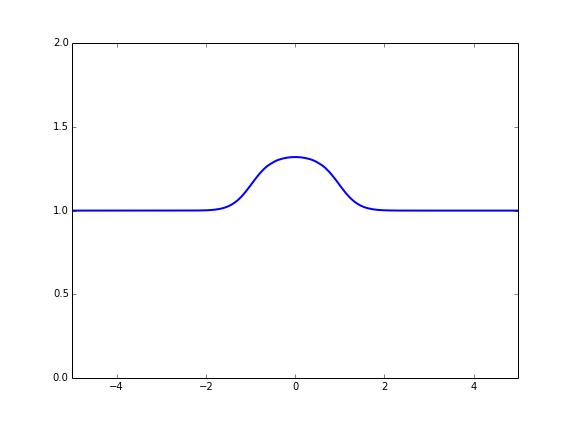
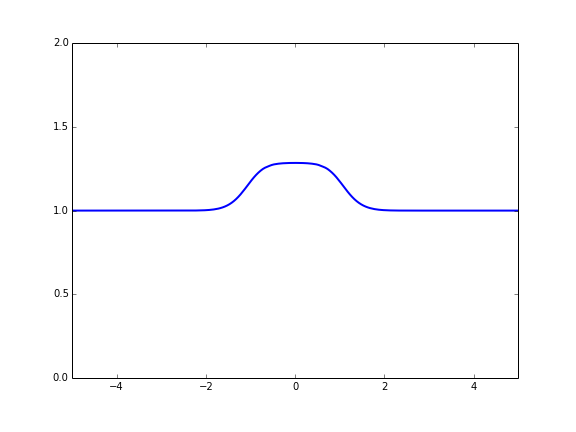
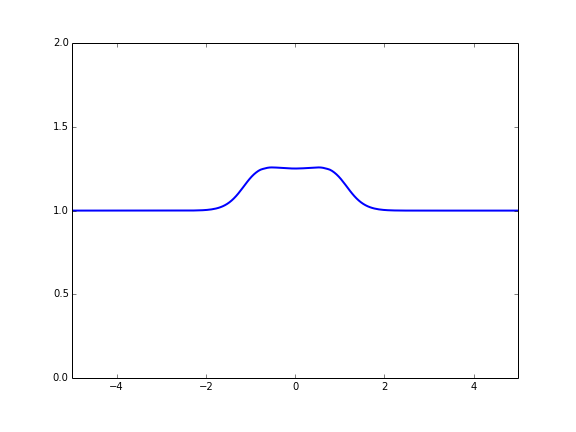
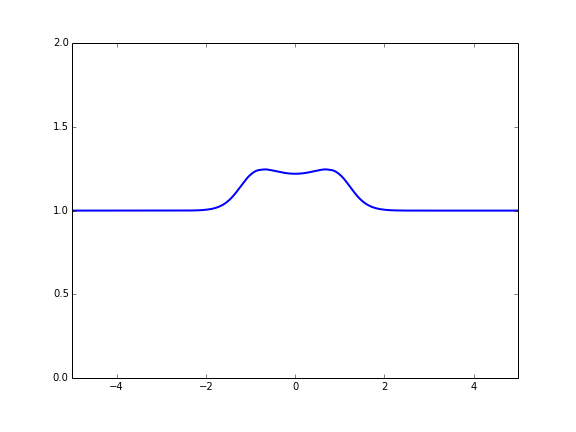
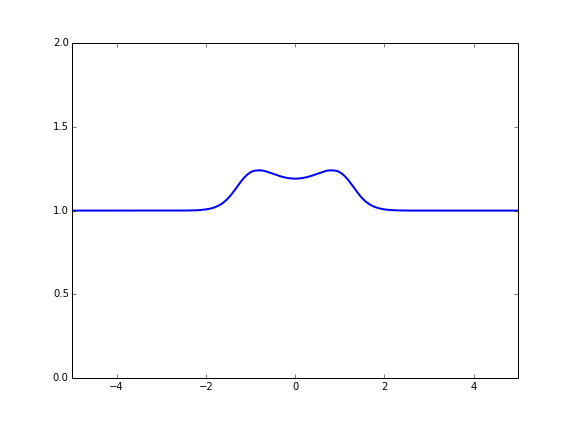
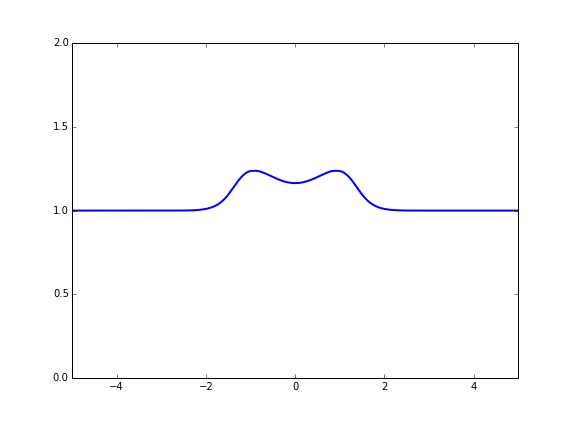
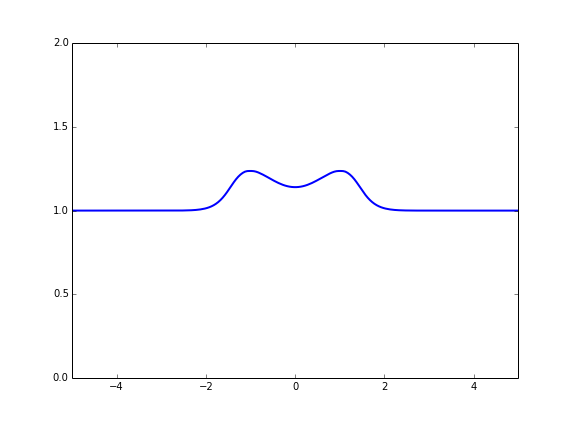
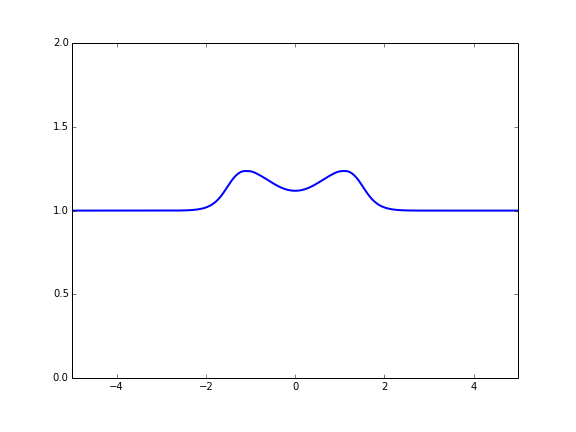
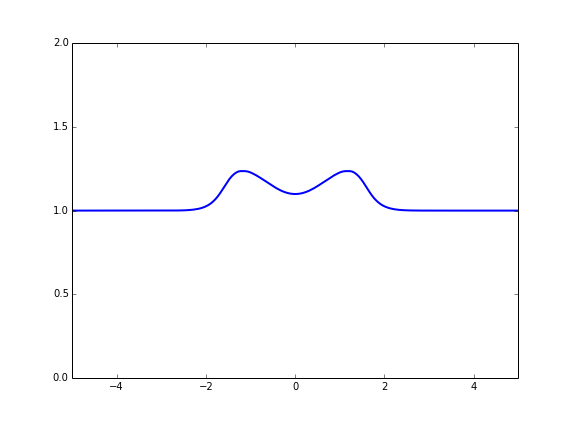
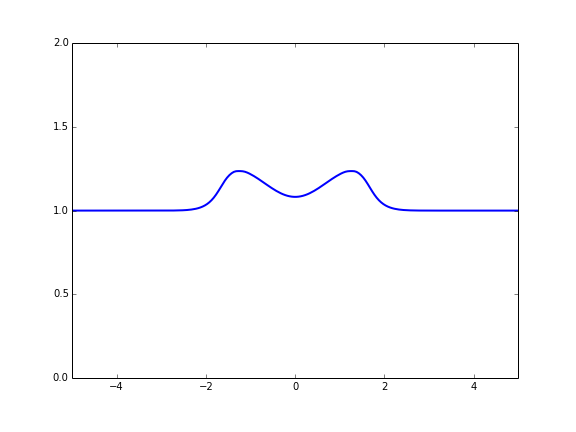
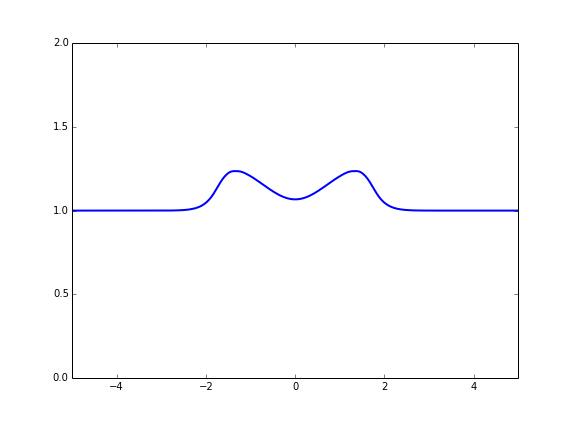
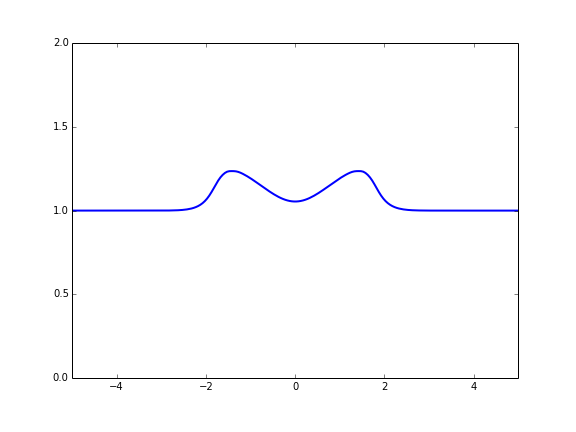
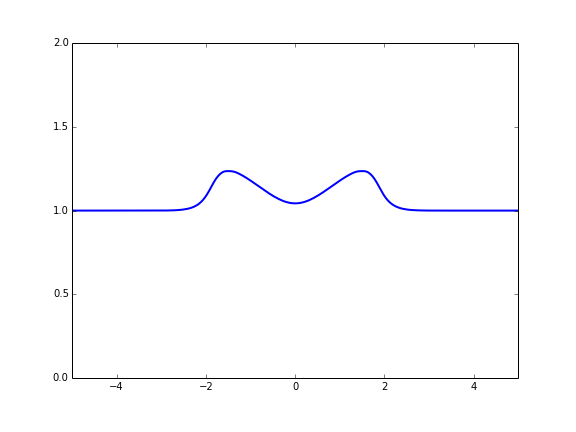
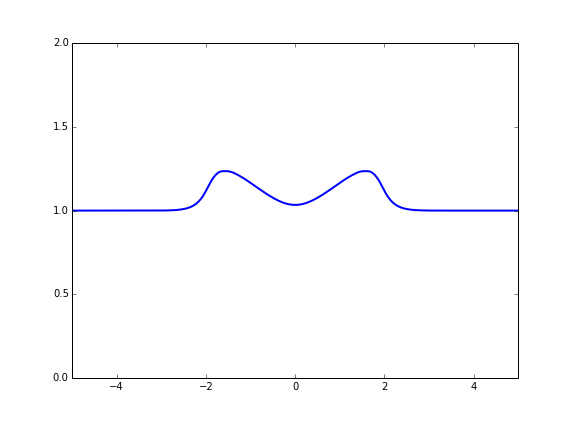
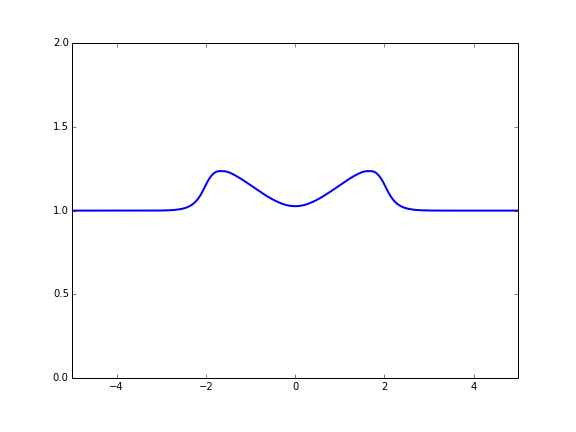
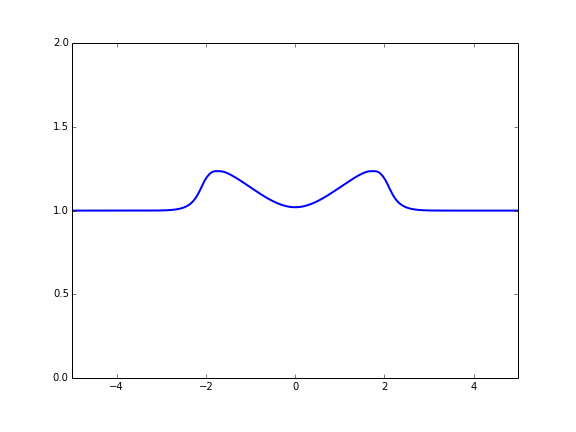
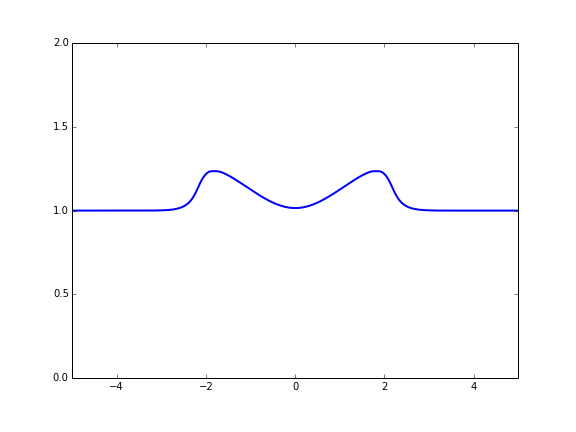
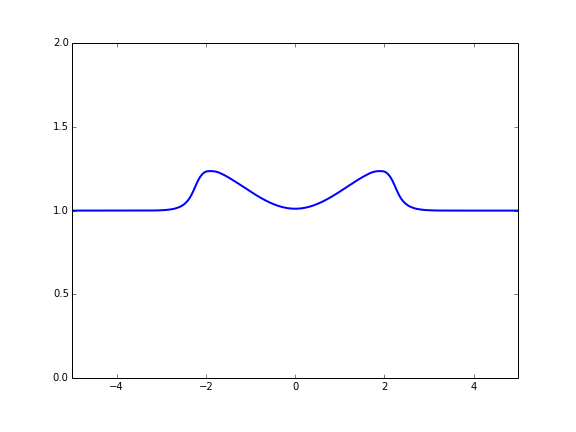
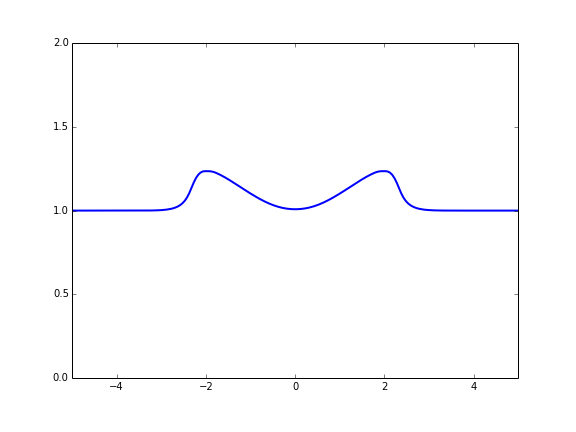
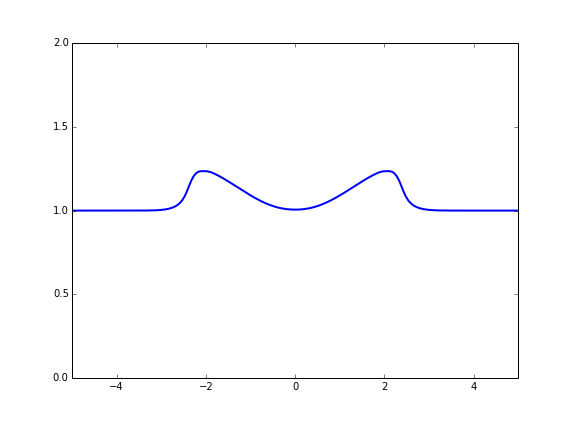
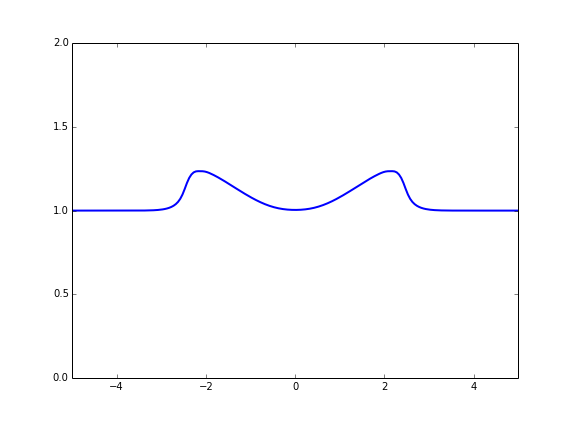
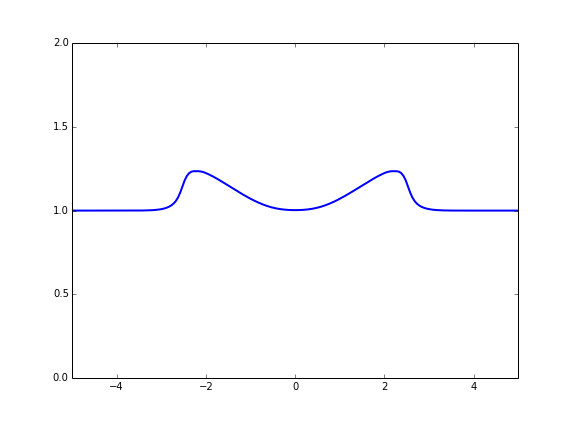
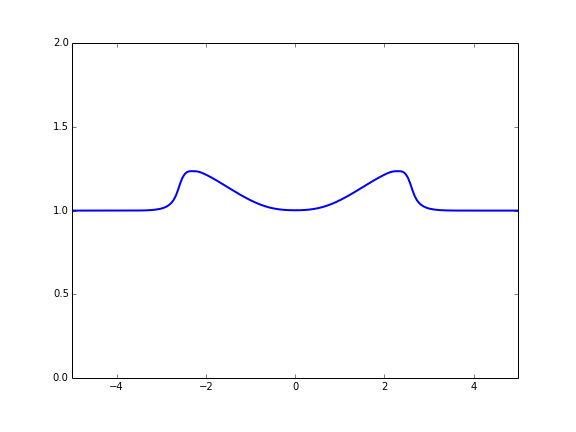
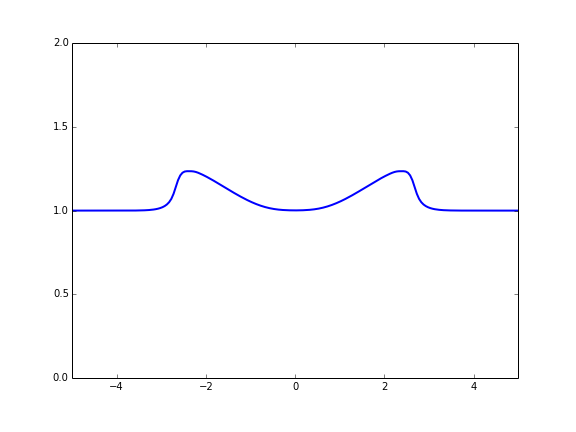
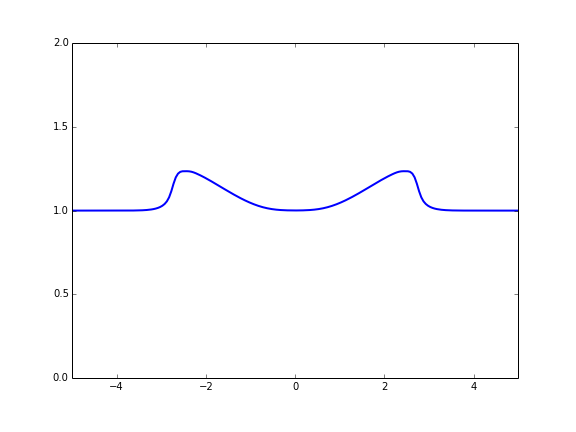
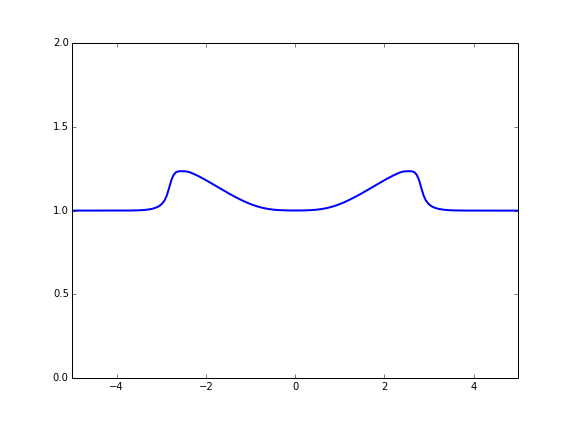
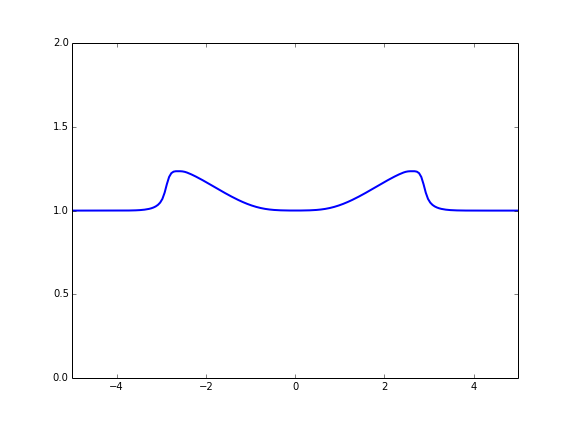
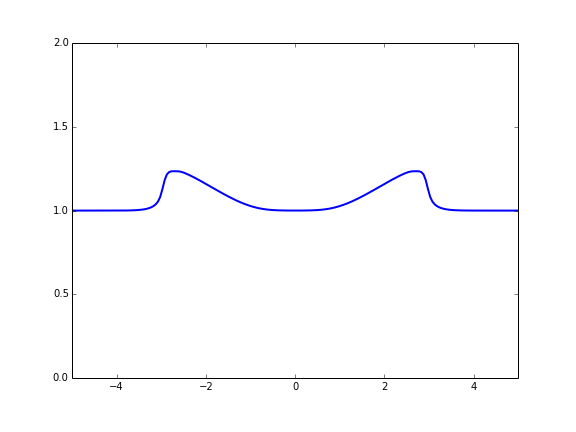
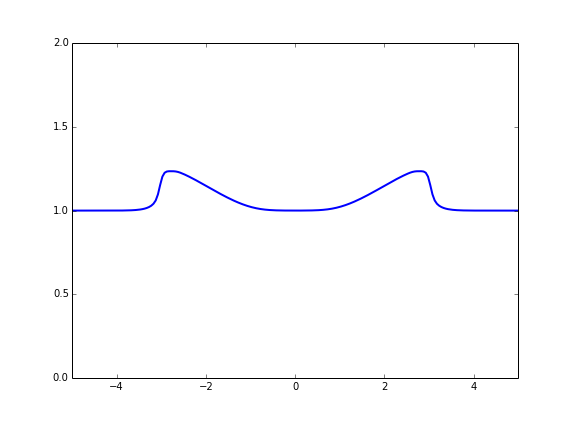
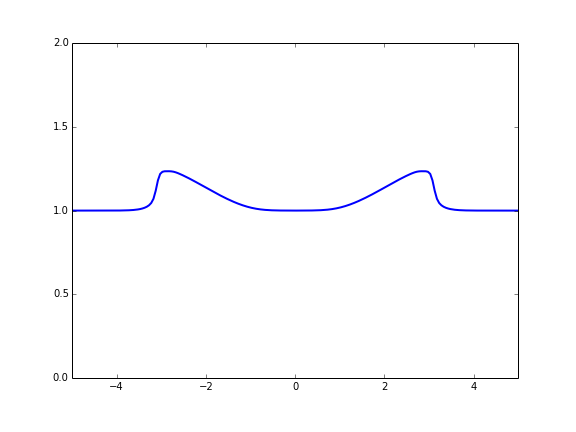
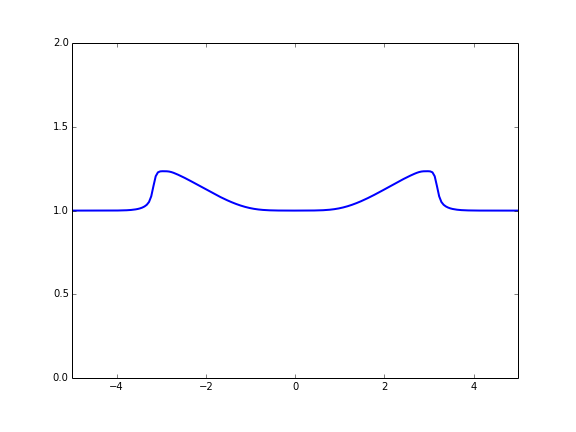
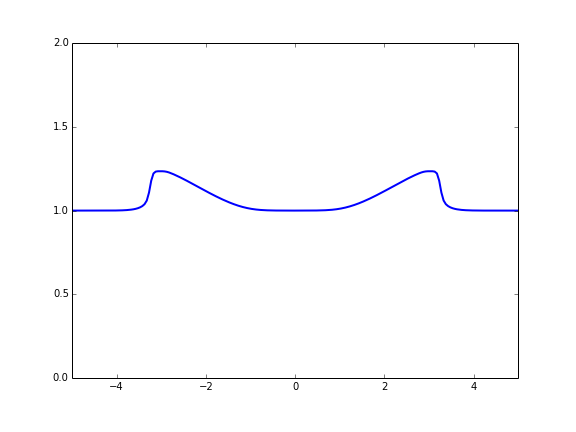
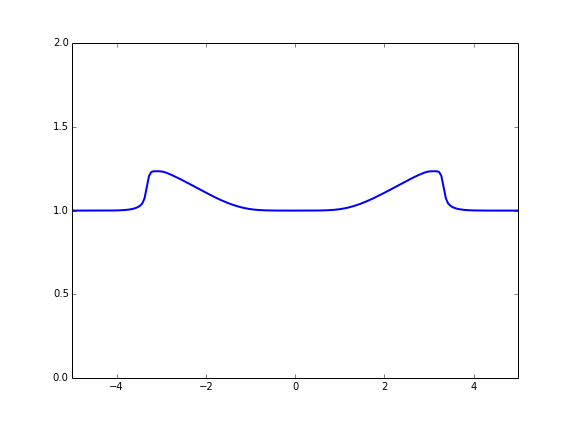
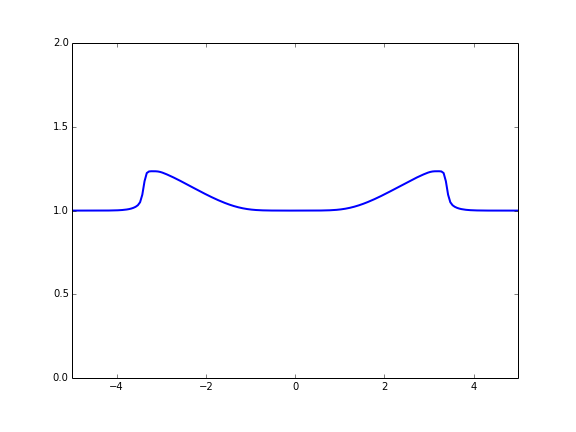
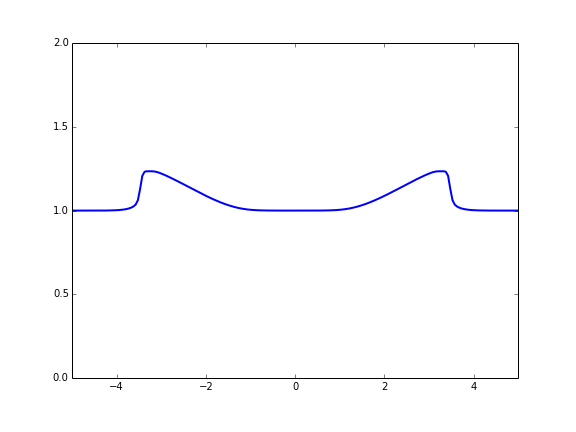
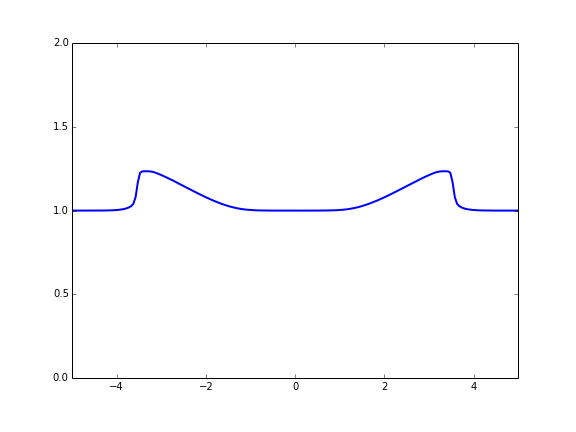
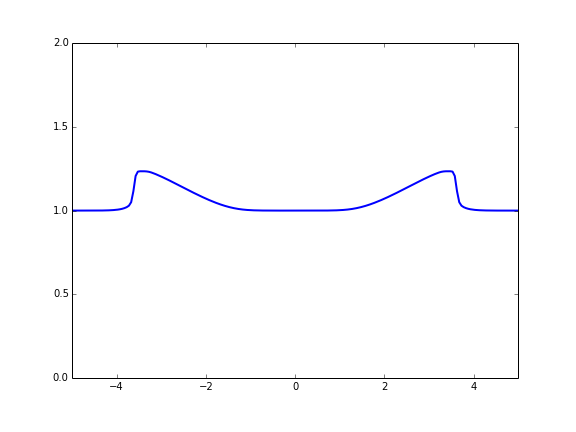
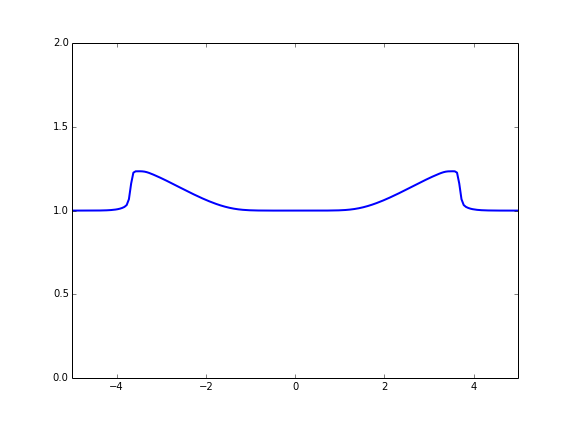
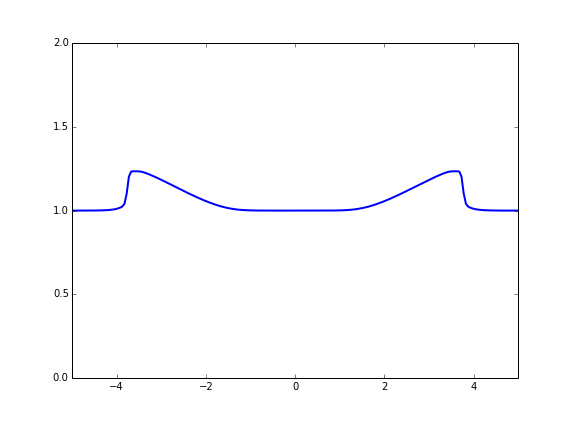
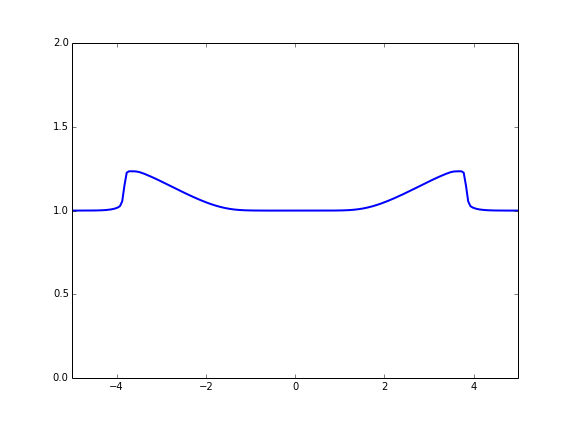
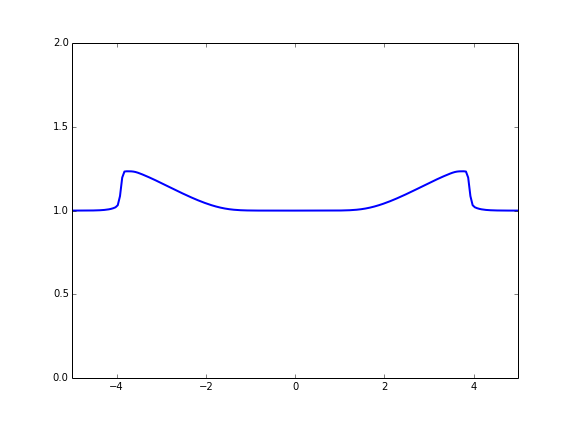
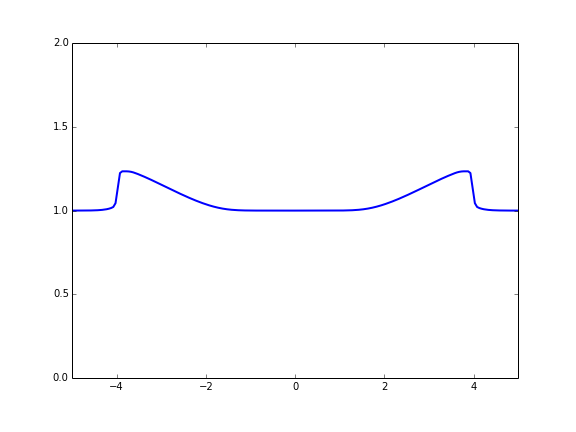
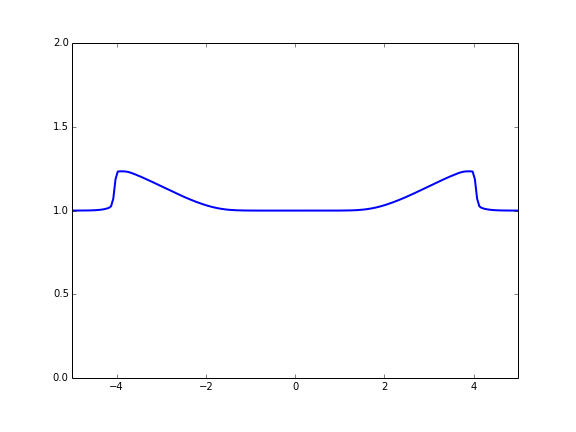

In [24]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(xlim=(-5, 5), ylim=(0, 2))

frame = claw.frames[0]
pressure = frame.q[0,:]
line, = ax.plot([], [], lw=2)

def fplot(i):
    frame = claw.frames[i]
    line.set_data(x,frame.q[0,:])
    return line,

animation.FuncAnimation(fig, fplot, 50, interval=40)

---
Jump to notebook2 : <a href='https://ec2-52-11-155-224.us-west-2.compute.amazonaws.com:8888/notebooks/NB2-BeachProfileDefault.ipynb'> Go to notebook2 </a>

---